In [9]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
from misc import get_attr
import time
pd.set_option('mode.chained_assignment', None)
from framework import tester, strategy



In [10]:
spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


{'Total Return': 10.719050239730775}


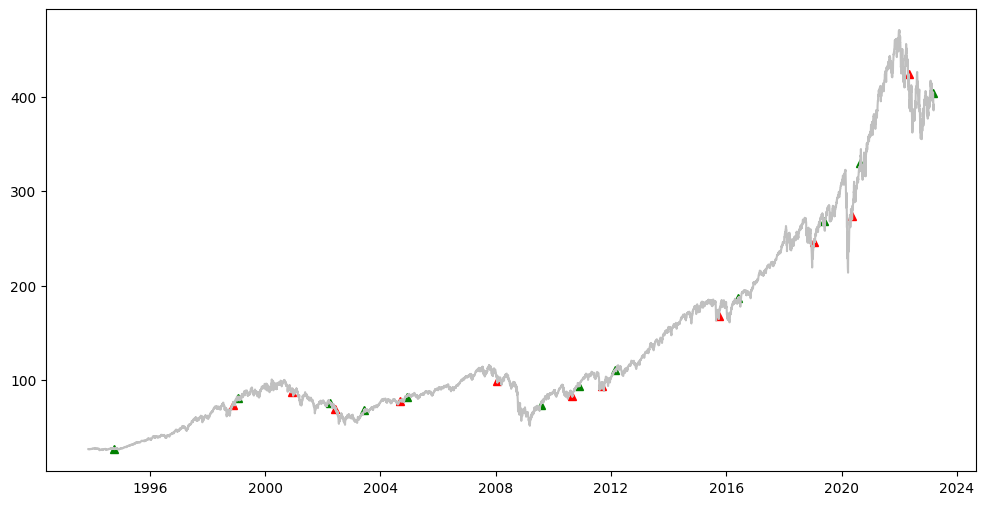

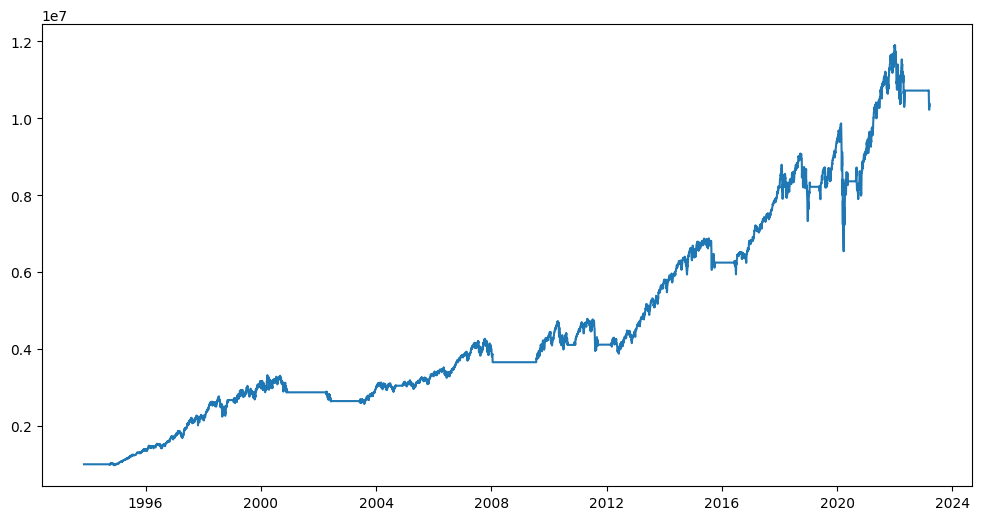

In [11]:
def ma_crossover(input_arr, trader_state, **kwargs):
    '''
    input_arr = ADJC, S, S+1
    trader_state = cash, position, position_value, portfolio_value, margin
    '''
    buy_threshold = get_attr(kwargs, 'buy_threshold', 0)
    sell_threshold = get_attr(kwargs, 'sell_threshold', 0)
    cash, position, _, _, _ = trader_state
    adjclose, signal, signal_1 = input_arr

    limit_order = np.zeros(2)
    if  signal > buy_threshold and signal_1 < buy_threshold:
        limit_order[0] = adjclose
        limit_order[1] = cash // adjclose
    elif signal < sell_threshold and signal_1 > sell_threshold:
        limit_order[0] = adjclose
        limit_order[1] = -position

    return limit_order

def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df.copy()
# df = df.iloc[-500:]
ma_strategy = strategy(ma_signal, ma_crossover)
test = tester(ma_strategy)
test.generate_signal(data_df=df, **{'short_period': 100, 'long_period': 200})
test.run_strategy(initial_capital=1e6, **{'buy_threshold': 0, 'sell_threshold': 0, 'strategy_input_features': ['adjclose', 'signal', 'signal+1']})
test.evaluate_strategy()
test.plot_results()



In [24]:
import gym
from gym import spaces

class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.action_space = spaces.Box(
            low=np.array([-1000000, -1000000]),
            high=np.array([100000, 100000]),
            dtype=np.float64
        )
        self.observation_space = spaces.Box(
            low=np.array([-1000000 for f in range(8)]),
            high=np.array([1000000 for f in range(8)]),
            dtype=np.float64
        )

        self.cash = 1e6
        self.positions = 0
        self.position_value = 0
        self.portfolio_value = 1e6
        self.leverage = 1
        self.current_step = 0
        self.df = df
    
    def reset(self):
        self.cash = 1e6
        self.position = 0
        self.position_value = 0
        self.portfolio_value = 1e6
        self.leverage = 1
        self.curent_step = 0

        return self.__next_observation()

    def __next_observation(self):
        obs = np.array([
            self.df.loc[self.df.index[self.current_step], 'adjclose'],
            self.df.loc[self.df.index[self.current_step], 'signal'],
            self.df.loc[self.df.index[self.current_step], 'signal+1'],
            self.cash,
            self.position,
            self.position_value,
            self.portfolio_value,
            self.leverage,
        ])

        return obs
    
    def step(self, action):
        self.__take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df) - 10:
            self.current_step = 0
        delay_mod = self.current_step / len(self.df)
        reward = self.portfolio_value * delay_mod
        done = self.portfolio_value <= 0
        obs = self.__next_observation()
        return obs, reward, done, {}
    
    def __take_action(self, action):
        order_price = action[0]
        order_quantity = action[1]
        # Update trader_state
        self.cash -= order_price * order_quantity
        self.position += order_quantity
        self.position_value = self.position * self.df.loc[self.df.index[self.current_step], 'adjclose']
        self.portfolio_value = self.cash + self.position_value
        self.leverage = self.position_value / self.portfolio_value
    
    def render(self, mode='human', close=False):
        print(f'Step: {self.current_step}')
        print(f'Portfolio value: {self.portfolio_value}')
        
        

In [31]:

from stable_baselines3 import PPO
import gym

df = spy_df[-600:].copy()
test1 = tester(ma_strategy)
test1.generate_signal(data_df=df, **{'short_period': 100, 'long_period': 200})
tdf = test1.df.copy()
# tdf = tdf[['date', 'adjclose', 'signal', 'signal+1']]

# env = DummyVecEnv([lambda: TradingEnv(tdf)])
env = TradingEnv(tdf)

model = PPO(policy = "MlpPolicy",env=env, verbose=3, device='cuda')
model.learn(total_timesteps=25000)

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()



c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2465 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1623          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.1641532e-10 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.84         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.58e+13      |
|    n_updates            | 10            |
|    policy_gradient_loss | -1.08e-0

In [33]:
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
env = make_vec_env("CartPole-v1", n_envs=4)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=25000)
model.save("ppo_cartpole")

del model # remove to demonstrate saving and loading

model = PPO.load("ppo_cartpole")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | 22.9     |
| time/              |          |
|    fps             | 8309     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.7       |
|    ep_rew_mean          | 35.7       |
| time/                   |            |
|    fps                  | 3175       |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01349753 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.682     |
|    explained_variance   | -0.000458  |
|    learning_rate        | 

KeyboardInterrupt: 

: 